In [43]:
library(tidyverse)
library(fda)

In [32]:
cm_k01_s19 <- 
    read.table("C:/Users/Personal/functional data analysis/Datos/2D_Res 32_Dom_48-16/distancia_2d_res32_dom48-16_s19.csv", 
              sep = "", header=TRUE)
cm_k01_s59 <- 
    read.table("C:/Users/Personal/functional data analysis/Datos/2D_Res 32_Dom_48-16/distancia_2d_res32_dom48-16_s59.csv",
            sep = "", header=TRUE)

v_k01_s19 <- 
    read.table("C:/Users/Personal/functional data analysis/Datos/2D_Res 32_Dom_48-16/velocidad_2d_res32_dom48-16_s19.csv", 
              sep = "", header=TRUE)
v_k01_s59 <- 
    read.table("C:/Users/Personal/functional data analysis/Datos/2D_Res 32_Dom_48-16/velocidad_2d_res32_dom48-16_s59.csv",
            sep = "", header=TRUE)

In [33]:
cm_k01_s19 <- cm_k01_s19 %>% mutate(Time = round(Time, 2))
cm_k01_s59 <- cm_k01_s59 %>% mutate(Time = round(Time, 2))

cm_k01 <- inner_join(cm_k01_s19, cm_k01_s59, by = 'Time', suffix = c('_sig16', '_sig56'))

In [34]:
v_k01_s19 <- v_k01_s19 %>% mutate(Time = round(Time, 2))
v_k01_s59 <- v_k01_s59 %>% mutate(Time = round(Time, 2))

v_k01 <- inner_join(v_k01_s19, v_k01_s59, by = 'Time', suffix = c('_sig16', '_sig56'))

In [35]:
# Use test data to learn the n_basis param. 
trainIndex <- seq(1, dim(cm_k01)[1], by = 2)
ntrain <- length(trainIndex)

cm_k01_train <- cm_k01 %>% slice(trainIndex)
cm_k01_test <- cm_k01 %>% slice(-trainIndex)

v_k01_train <- v_k01 %>% slice(trainIndex)
v_k01_test <- v_k01 %>% slice(-trainIndex)

In [36]:
paddingDf <- function(df, paddMin, paddSize){
    # Padding the training matrix to avoid problems at the boundary
    paddingMat <- matrix(rep(as.matrix(df[1, ]) , each = paddSize), nrow = paddSize, ncol=dim(df)[2])
    padding <- data.frame(paddingMat) 
    names(padding) <- names(df)
    padding <- padding %>% mutate(Time = seq(paddMin, -1, length.out = paddSize))

    df_padd <- rbind(padding, df)
    return(df_padd)
}

In [37]:
paddMin <- -10
paddSize <- 10/0.2 # sample at the same rate as on the data set

cm_k01_train <- paddingDf(cm_k01_train, paddMin, paddSize)
v_k01_train <- paddingDf(v_k01_train, paddMin, paddSize)

## Choosing a basis

We'll use b-splines of order 6 since we are interested in the acceleration of the data. The basis will have ~6*2 basis elements. More elements could be used with a roughness a penalty. 

There are some problems at the boundaries. It would be nice to have some extra time before the wave crashes into the cloud (will do this: in fact all the values are the same as at t=0 before the shock).

In [48]:
Time <- cm_k01$Time
endTime <- Time[length(Time)]

# basis defined over [paddMin, 40]
basis13 <- create.bspline.basis(c(paddMin, endTime), 13, 6)

In [49]:
Time <- cm_k01_train$Time
TestTime <- cm_k01_test$Time

cmMatrix <- as.matrix(cm_k01_train %>% select(-Time))
index <- seq(1, dim(cmMatrix)[2], by = 2)
cmxMatrix <- cmMatrix[, index]
cmyMatrix <- cmMatrix[, -index]

vMatrix <- as.matrix(v_k01_train %>% select(-Time))
index <- seq(1, dim(vMatrix)[2], by = 2)
vxMatrix <- vMatrix[, index]
vyMatrix <- vMatrix[, -index]

In [50]:
smoothCMx <- smooth.basis(argvals = Time, y = cmxMatrix, basis13)
smoothCMy <- smooth.basis(argvals = Time, y = cmyMatrix, basis13)
coefCMx <- smoothCMx$fd$coefs
coefCMy <- smoothCMy$fd$coefs

smoothVx <- smooth.basis(argvals = Time, y = vxMatrix, basis13)
smoothVy <- smooth.basis(argvals = Time, y = vyMatrix, basis13)
coefVx <- smoothVx$fd$coefs
coefVy <- smoothVy$fd$coefs

In [51]:
# Evaluating the basis functions on the Time vector. 
basisMat13 <- eval.basis(evalarg = Time, basisobj = basis13)
DbasisMat13 <- eval.basis(evalarg = Time, basisobj = basis13, Lfdobj = 1)
DDbasisMat13 <- eval.basis(evalarg = Time, basisobj = basis13, Lfdobj = 2)

# Prediction
predCMx <- basisMat13 %*% coefCMx
predCMy <- basisMat13 %*% coefCMy

predVx <- basisMat13 %*% coefVx
predVy <- basisMat13 %*% coefVy

# Derivatives predictions
DpredCMx <- DbasisMat13 %*% coefCMx
DpredCMy <- DbasisMat13 %*% coefCMy

DDpredCMx <- DDbasisMat13 %*% coefCMx
DDpredCMy <- DDbasisMat13 %*% coefCMy

DpredVx <- DbasisMat13 %*% coefVx
DpredVy <- DbasisMat13 %*% coefVy

# The Whole picture

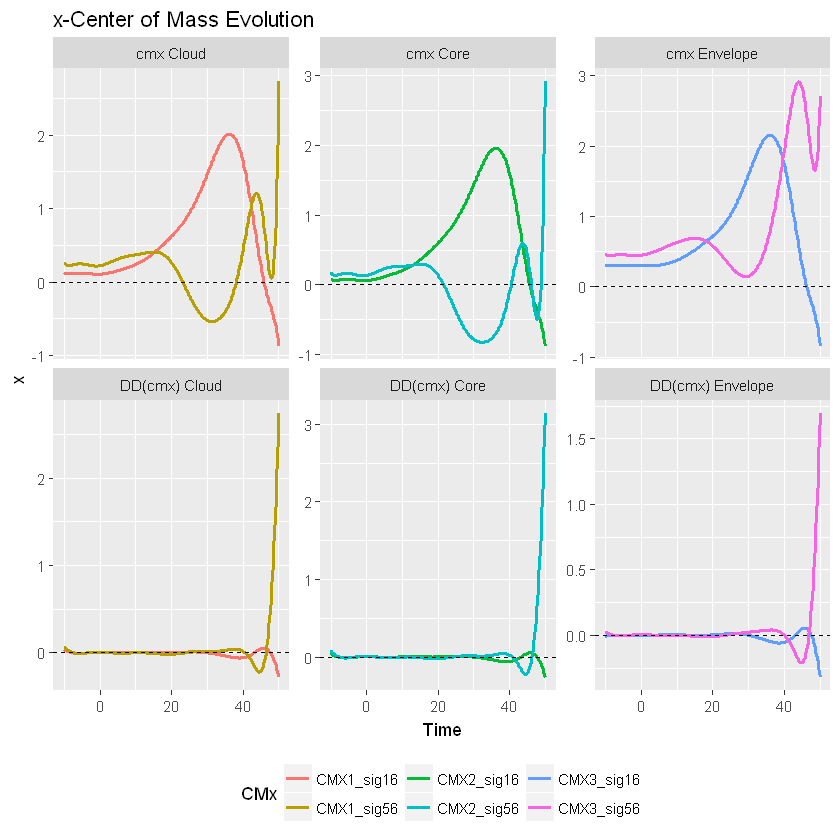

In [52]:
# CMx plots with acceleration
Tracer <- rep(rep(c('cmx Cloud', 'cmx Core', 'cmx Envelope'), each=ntrain + paddSize), times=2)
DDTracer <- rep(rep(c('DD(cmx) Cloud', 'DD(cmx) Core', 'DD(cmx) Envelope'), each=ntrain + paddSize), times=2)

CMx_obs <- data.frame(cmxMatrix) %>% mutate(Time = Time) %>% 
                                        gather(CMx, x, -Time) %>% mutate(Tracer = Tracer)
CMx_pred <- data.frame(predCMx) %>% mutate(Time = Time) %>% 
                                        gather(CMx, x, -Time) %>% mutate(Tracer = Tracer)
DDCMx_pred <- data.frame(DDpredCMx) %>% mutate(Time = Time) %>% 
                                        gather(DDCMx, x, -Time) %>% mutate(Tracer = DDTracer)

# to plot one at a time: CMx_pred_plot <- CMx_pred %>% filter(Sim == 3)
ggplot() + geom_line(data = CMx_pred, aes(Time, x, color=CMx), size=1) + 
            geom_line(data = DDCMx_pred, aes(Time, x, color=DDCMx), size=1) +
            geom_hline(yintercept = 0, linetype=2) +
            facet_wrap( ~ Tracer, scales="free_y", ncol=3) +
            ggtitle("x-Center of Mass Evolution") +
            theme(legend.position="bottom")

In [53]:
accelerationPlots <- function(predMat, LpredMat, npoints, paddMin, paddMax, ylims, title, legend1, legend2, ...){
    
    # inputs: Mat: 
    #         predMat: matrix with predictions.
    #         LpredMat: Derivative predictions.
    #         npoints: number of prediction points.
    #         paddMax: erase points from the end of the vector of predictions. 
    #
    #
    
    NPindex <- (paddMin+1):(dim(cmxMatrix)[1]-paddMax)
    
    # Names for the tracer:  
    Tracer <- rep(rep(legend1, each=npoints - paddMax), times=2)
    DDTracer <- rep(rep(legend2, each=npoints - paddMax), times=2)

    # Formating the data: 
    
    CMy_pred <- data.frame(predMat[NPindex, ]) %>% mutate(Time = Time[NPindex]) %>% 
                                            gather(sigma, y, -Time) %>% mutate(Tracer = Tracer)

    DDCMy_pred <- data.frame(LpredMat[NPindex, ]) %>% mutate(Time = Time[NPindex]) %>% 
                                            gather(DDCM, y, -Time) %>% mutate(Tracer = DDTracer)

    # Setting the limits for each plot: 
    legend <- c(legend1, legend2)
    n1 <- DDCMy_pred[1, 2] # pick a name in the df.
    dfLimits <- data.frame(Time= rep(0,6), sigma = rep(n1,6), y = ylims, Tracer = legend)

    p <- ggplot() +  geom_line(data = CMy_pred, aes(Time, y, color=sigma), size=1) + 
                geom_line(data = DDCMy_pred, aes(Time, y, color=DDCM), size=1) +
                geom_hline(yintercept = 0, linetype=2) + 
                geom_point(data = dfLimits, aes(Time, y, color=sigma), alpha=0) +
                facet_wrap( ~ Tracer, scales="free_y", ncol=3) +
                ggtitle(title) +
                ylab('') + 
                theme(legend.position="bottom")
    
    return(p)
}


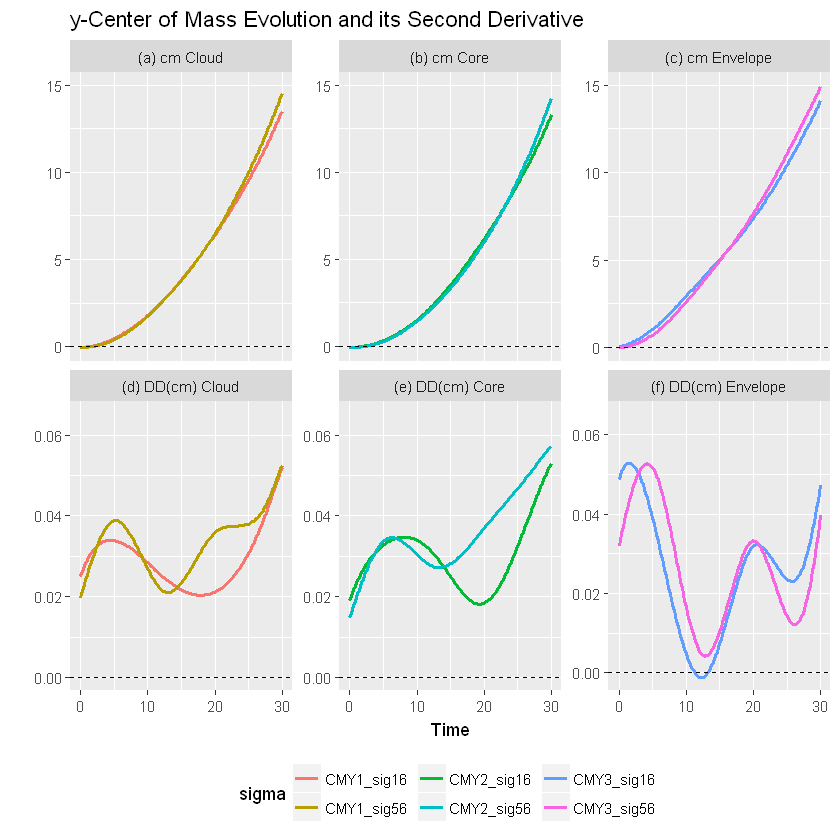

In [54]:
ylims <- c(15, 15, 15, 0.065, 0.065, 0.065) 
title <- "y-Center of Mass Evolution and its Second Derivative"
legend1 <- c('(a) cm Cloud', '(b) cm Core', '(c) cm Envelope')
legend2 <- c('(d) DD(cm) Cloud', '(e) DD(cm) Core', '(f) DD(cm) Envelope')
paddMin <- paddSize
paddMax <- 100
pcm <- accelerationPlots(predCMy, DDpredCMy, ntrain, paddMin, paddMax, ylims, title, legend1, legend2)

#png("cmy.png", width = 10, height = 7, units = 'in', res = 300)
pcm
#dev.off()

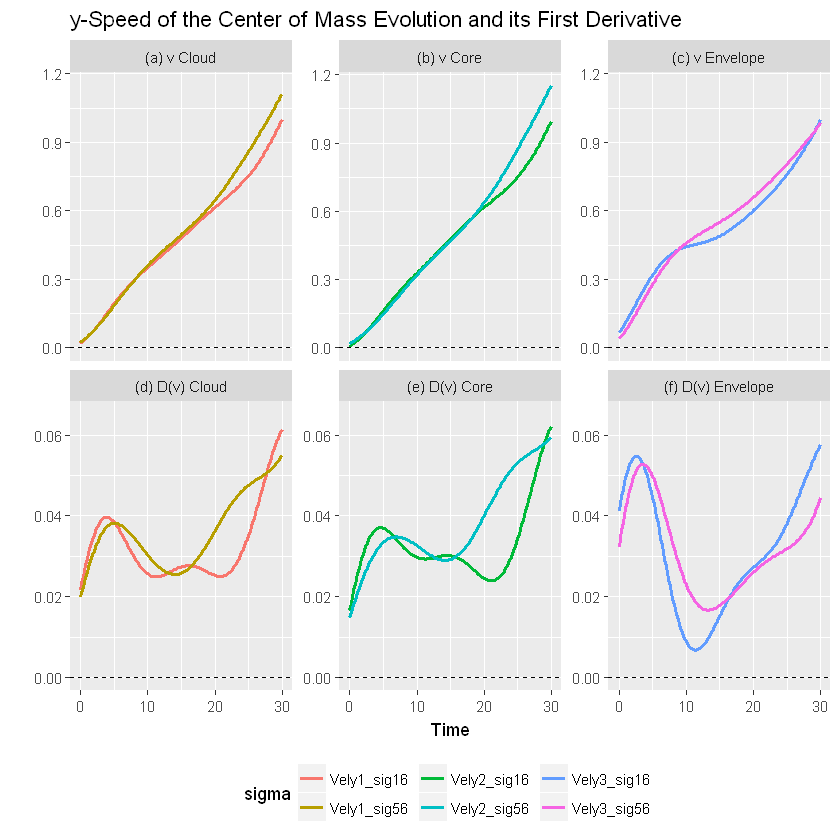

In [15]:
ylims <- c(1.15, 1.15, 1.15, 0.065, 0.065, 0.065) 
title <- "y-Speed of the Center of Mass Evolution and its First Derivative"
legend1 <- c('(a) v Cloud', '(b) v Core', '(c) v Envelope')
legend2 <- c('(d) D(v) Cloud', '(e) D(v) Core', '(f) D(v) Envelope')
paddMin <- paddSize
paddMax <- 100
pvy <- accelerationPlots(predVy, DpredVy, ntrain, paddMin, paddMax, ylims, title, legend1, legend2)

#png("vy.png", width = 10, height = 7, units = 'in', res = 300)
pvy
#dev.off()

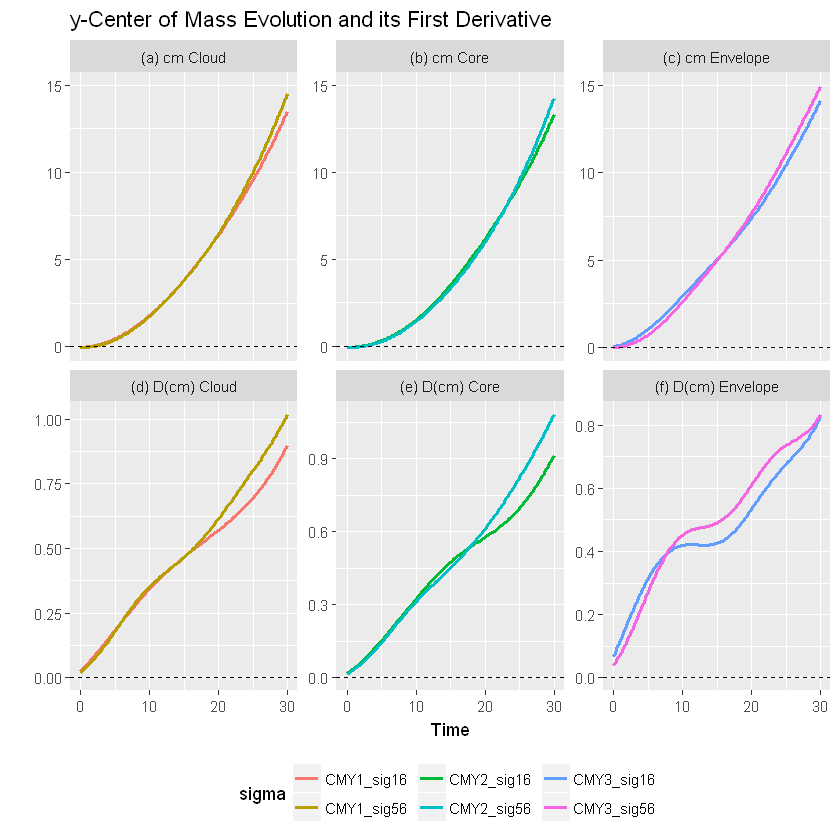

In [16]:
ylims <- c(15, 15, 15, 0.065, 0.065, 0.065) 
title <- "y-Center of Mass Evolution and its First Derivative"
legend1 <- c('(a) cm Cloud', '(b) cm Core', '(c) cm Envelope')
legend2 <- c('(d) D(cm) Cloud', '(e) D(cm) Core', '(f) D(cm) Envelope')
paddMin <- paddSize
paddMax <- 100
pcm <- accelerationPlots(predCMy, DpredCMy, ntrain, paddMin, paddMax, ylims, title, legend1, legend2)


#png("cmyV.png", width = 10, height = 7, units = 'in', res = 300)
pcm
#dev.off()

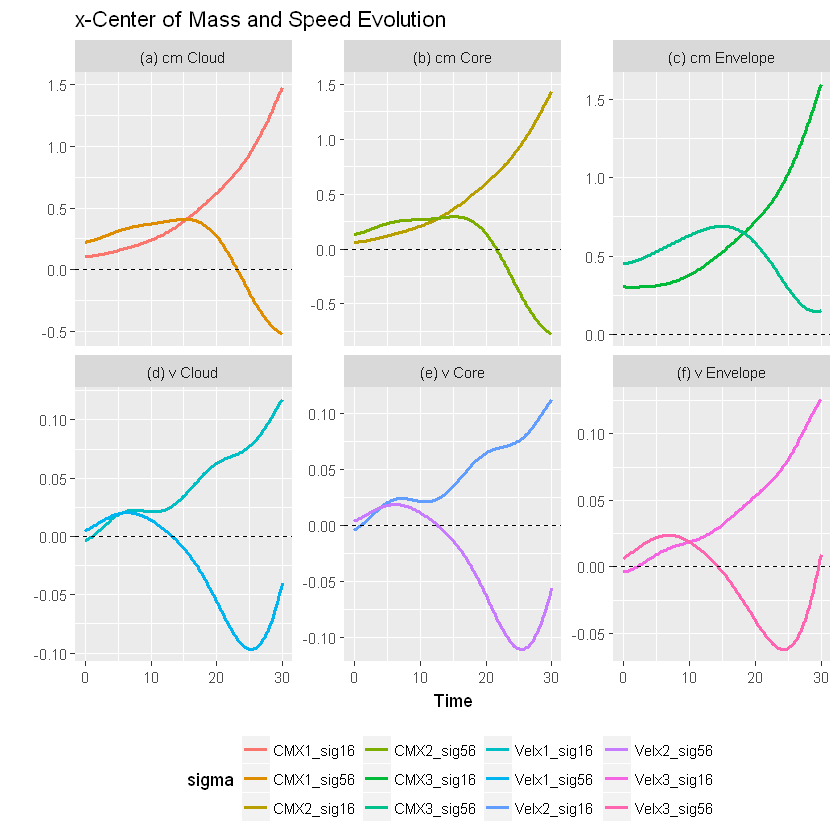

In [17]:
ylims <- c(1.5, 1.5, 1.5, 0.01, 0.01, 0.01) 
title <- "x-Center of Mass and Speed Evolution"
legend1 <- c('(a) cm Cloud', '(b) cm Core', '(c) cm Envelope')
legend2 <- c('(d) v Cloud', '(e) v Core', '(f) v Envelope')
paddMin <- paddSize
accelerationPlots(predCMx, predVx, ntrain, paddMin, paddMax, ylims, title, legend1, legend2)

# Choosing the order and the number of basis elements. 

In [ ]:
plotCurves <- function(CM1, CM2){
    cm_k01_plot <- cm_k01 %>% select(Time, CM1, CM2) %>% gather(Sigma, CMX, -Time)
    p <- ggplot(cm_k01_plot, aes(Time, CMX, color=Sigma)) + geom_line(size = 1)
    return(p)
}

pY1 <- plotCurves("CMY1_sig16", "CMY1_sig56")
pY2 <- plotCurves("CMY2_sig16", "CMY2_sig56")
pY3 <- plotCurves("CMY3_sig16", "CMY3_sig56")

#multiplot(pY1, pY2, pY3, cols = 1)

In [8]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}